In [1]:
import tensorflow as tf

In [2]:
DATASET_DIR = '../Data/Stanford_Online_Products/'
FULL_DATASET_FILE = 'Ebay_info.txt'

In [5]:
class DataHandler:

    def __init__(self, dataset_dir,
                 split_dataset=0.2,
                 batch_size=16,
                 target_shape=(400, 400)):
        self.__target_shape = target_shape
        self.__dataset_dir = dataset_dir

        self.__dataset_partitions = split_dataset

        self.__train, self.__validation = self.__generate_dataset(batch_size=batch_size)

    def __generate_dataset(self, batch_size):
        data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                         width_shift_range=0.2,
                                                                         height_shift_range=0.2,
                                                                         shear_range=0.2,
                                                                         zoom_range=0.2,
                                                                         horizontal_flip=True,
                                                                         fill_mode='nearest',
                                                                         validation_split=self.__dataset_partitions)

        train = data_generator.flow_from_directory(self.__dataset_dir, class_mode="categorical",
                                                   target_size=self.__target_shape, color_mode='rgb',
                                                   batch_size=batch_size, shuffle=True, subset='training')

        validation = data_generator.flow_from_directory(self.__dataset_dir, class_mode="categorical",
                                                        target_size=self.__target_shape, color_mode='rgb',
                                                        batch_size=batch_size, shuffle=True, subset='validation')

        return train, validation

    def get_train(self):
        return self.__train

    def get_validation(self):
        return self.__validation

    def get_shape(self):
        return self.__target_shape

In [6]:
data_handler = DataHandler(dataset_dir=DATASET_DIR, target_shape=(128, 128), batch_size=64)

train = data_handler.get_train()
validation = data_handler.get_validation()

Found 96047 images belonging to 12 classes.
Found 24006 images belonging to 12 classes.


In [7]:
type(train)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

C:\Users\Nitcu\.conda\envs\tenorflow-gpu\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


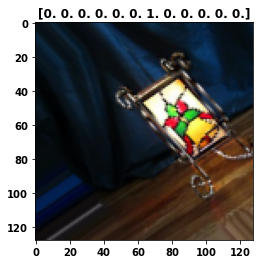

In [8]:
from matplotlib import pyplot as plt

first_batch = next(iter(train))

NUM_IMAGE = 8

fig, ax = plt.subplots(1)
ax.set_title(first_batch[1][NUM_IMAGE])
ax.imshow(first_batch[0][NUM_IMAGE].astype(int))

Функция потерь

In [9]:
class TripletHardLoss(tf.keras.losses.Loss):

    def __init__(self, margin=0.5):
        super().__init__()
        self.__margin = margin

    @tf.autograph.experimental.do_not_convert
    def call(self, y_true, y_pred):
        labels = tf.convert_to_tensor(y_true, name="labels")
        embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

        convert_to_float32 = (
                embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
        )
        precise_embeddings = (
            tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
        )

        batch_size = tf.shape(precise_embeddings)[0]
        adjacency_matrix = tf.matmul(labels, labels, transpose_b=True)
        adjacency_matrix = tf.cast(adjacency_matrix, tf.bool)
        negative_adjacency = tf.math.logical_not(adjacency_matrix)
        negative_adjacency = tf.cast(negative_adjacency, dtype=tf.dtypes.float32)
        positive_adjacency = tf.cast(adjacency_matrix, dtype=tf.dtypes.float32) - tf.eye(batch_size,
                                                                                         dtype=tf.float32)

        dist = tf.sqrt(
            tf.math.reduce_sum(tf.square(
                tf.tile(precise_embeddings, [batch_size, 1]) - tf.repeat(precise_embeddings,
                                                                         repeats=batch_size,
                                                                         axis=0)), axis=1))

        distance_embeddings = tf.reshape(dist, [batch_size, batch_size])

        hard_positives = self.__maximum_dist(distance_embeddings, positive_adjacency)
        hard_negatives = self.__minimum_dist(distance_embeddings, negative_adjacency)

        triplet_loss = tf.maximum(hard_positives - hard_negatives + self.__margin, 0.0)
        triplet_loss = tf.reduce_mean(triplet_loss)

        if convert_to_float32:
            return tf.cast(triplet_loss, embeddings.dtype)
        else:
            return triplet_loss

    def __minimum_dist(self, data, mask):
        axis_maximums = tf.math.reduce_max(data, 1, keepdims=True)

        masked_minimums = (
                tf.math.reduce_min(
                    tf.math.multiply(data - axis_maximums, mask), 1, keepdims=True
                )
                + axis_maximums
        )
        return masked_minimums

    def __maximum_dist(self, data, mask):
        axis_minimums = tf.math.reduce_min(data, 1, keepdims=True)

        masked_maximums = (
                tf.math.reduce_max(
                    tf.math.multiply(data - axis_minimums, mask), 1, keepdims=True
                )
                + axis_minimums
        )

        return masked_maximums


In [13]:
from tensorflow.keras.applications import resnet


class EmbeddingModel(tf.keras.Model):

    def __init__(self, target_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__base_cnn = resnet.ResNet50(
            weights="imagenet", input_shape=target_shape + (3,), include_top=False
        )

        trainable = False
        for layer in self.__base_cnn.layers:
            if layer.name == "conv5_block1_out":
                trainable = True
            layer.trainable = trainable

        self.__flatten_1 = tf.keras.layers.Flatten()
        self.__dense_1 = tf.keras.layers.Dense(1024, activation="tanh")
        self.__batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.__dense_2 = tf.keras.layers.Dense(512, activation="tanh")
        self.__batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.__embedding = tf.keras.layers.Dense(256, kernel_regularizer='l2')

    @tf.autograph.experimental.do_not_convert
    def call(self, inputs, training=None, mask=None):
        layer = self.__base_cnn(inputs)
        layer = self.__flatten_1(layer)
        layer = self.__dense_1(layer)
        layer = self.__batch_norm_1(layer)
        layer = self.__dense_2(layer)
        layer = self.__batch_norm_2(layer)
        layer = self.__embedding(layer)
        return layer

    def get_config(self):
        return {
            '__flatten_1': self.__flatten_1,
            '__dense_1': self.__dense_1,
            '__batch_norm_1': self.__batch_norm_1,
            '__dense_2': self.__dense_2,
            '__batch_norm': self.__batch_norm_2,
            '__embedding': self.__embedding,
            '__base_cnn': self.__base_cnn
        }

    def from_config(cls, config, custom_objects=None):
        return cls(**config)

In [14]:
embedding_model = EmbeddingModel(target_shape=data_handler.get_shape())
embedding_model.compile(optimizer='adam', loss=TripletHardLoss(margin=0.5))

In [ ]:
embedding_model.fit(train, batch_size=64, validation_data=validation, epochs=50)

Epoch 1/50
1295/1501 [========================>.....] - ETA: 8:44 - loss: 2.7968   